## 训练U-Net模型

In [1]:
import json
import os

import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from dataset import BrainSegmentationDataset as Dataset
from logger import Logger
from loss import DiceLoss
from transform import transforms
from unet import UNet
from utils import log_images, dsc

import numpy as np
import matplotlib.pyplot as plt

/home/shaw/anaconda3/envs/hw4/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shaw/anaconda3/envs/hw4/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/shaw/anaconda3/envs/hw4/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# 读取数据
def data_loaders(args):
    dataset_train, dataset_valid = datasets(args)

    def worker_init(worker_id):
        np.random.seed(42 + worker_id)

    loader_train = DataLoader(
        dataset_train,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=args.workers,
        worker_init_fn=worker_init,
    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=args.batch_size,
        drop_last=False,
        num_workers=args.workers,
        worker_init_fn=worker_init,
    )

    return loader_train, loader_valid

# 数据集定义
def datasets(args):
    train = Dataset(
        images_dir=args.images,
        subset="train",
        image_size=args.image_size,
        transform=transforms(scale=args.aug_scale, angle=args.aug_angle, flip_prob=0.5),
    )
    valid = Dataset(
        images_dir=args.images,
        subset="validation",
        image_size=args.image_size,
        random_sampling=False,
    )
    return train, valid

# 数据处理
def dsc_per_volume(validation_pred, validation_true, patient_slice_index):
    dsc_list = []
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        y_pred = np.array(validation_pred[index : index + num_slices[p]])
        y_true = np.array(validation_true[index : index + num_slices[p]])
        dsc_list.append(dsc(y_pred, y_true))
        index += num_slices[p]
    return dsc_list


def log_loss_summary(logger, loss, step, prefix=""):
    logger.scalar_summary(prefix + "loss", np.mean(loss), step)


def makedirs(args):
    os.makedirs(args.weights, exist_ok=True)
    os.makedirs(args.logs, exist_ok=True)


def snapshotargs(args):
    args_file = os.path.join(args.logs, "args.json")
    with open(args_file, "w") as fp:
        json.dump(vars(args), fp)

In [3]:
exec_result = pd.DataFrame(columns=['epoch', 'val_loss', 'val_dsc'])

### 输入参数  

device: 设备编号  
batch_size: 批大小  
epochs: 训练轮数  
lr: 学习率  
vis_images: 可视化预测结果的数目 (在tensorboard中查看)  
vis_freq: 两次可视化预测结果的间隔  
weights: 训练后的模型参数路径    
images: 数据集路径   
image_size: 图像尺寸   
aug_scale: 数据增强(放缩)  
aug_angle: 数据增强(旋转)  

In [4]:
class Args:
    device = 'cuda:0'
    batch_size = 16
    epochs = 100
    lr = 0.0001
    workers = 4
    vis_images = 200
    vis_freq = 10
    weights = './weights'
    logs = './logs'
    images = './kaggle_3m'
    image_size = 256
    aug_scale = 0.05
    aug_angle = 15

数据处理和数据增强

In [5]:
args=Args()

makedirs(args)
snapshotargs(args)
device = torch.device("cpu" if not torch.cuda.is_available() else args.device)

loader_train, loader_valid = data_loaders(args)
loaders = {"train": loader_train, "valid": loader_valid}

reading train images...
preprocessing train volumes...
cropping train volumes...
padding train volumes...
resizing train volumes...


100it [00:53,  1.87it/s][00:53<00:00,  2.69it/s]
100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


normalizing train volumes...
done creating train dataset
reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...


10it [00:07,  1.35it/s]00:07<00:03,  1.01it/s]
100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


normalizing validation volumes...
done creating validation dataset


In [6]:
def main(args):

    unet = UNet(in_channels=Dataset.in_channels, out_channels=Dataset.out_channels)
    unet.to(device)

    dsc_loss = DiceLoss()
    best_validation_dsc = 0.0

    optimizer = optim.Adam(unet.parameters(), lr=args.lr)

    logger = Logger(args.logs)
    loss_train = []
    loss_valid = []

    step = 0

    for epoch in range(args.epochs):
        for phase in ["train", "valid"]:
            if phase == "train":
                unet.train()
            else:
                unet.eval()

            validation_pred = []
            validation_true = []

            for i, data in enumerate(loaders[phase]):
                if phase == "train":
                    step += 1

                x, y_true = data
                x, y_true = x.to(device), y_true.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    y_pred = unet(x)

                    loss = dsc_loss(y_pred, y_true)

                    if phase == "valid":
                        loss_valid.append(loss.item())
                        y_pred_np = y_pred.detach().cpu().numpy()
                        validation_pred.extend(
                            [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                        )
                        y_true_np = y_true.detach().cpu().numpy()
                        validation_true.extend(
                            [y_true_np[s] for s in range(y_true_np.shape[0])]
                        )
                        if (epoch % args.vis_freq == 0) or (epoch == args.epochs - 1):
                            if i * args.batch_size < args.vis_images:
                                tag = "image/{}".format(i)
                                num_images = args.vis_images - i * args.batch_size
                                logger.image_list_summary(
                                    tag,
                                    log_images(x, y_true, y_pred)[:num_images],
                                    step,
                                )

                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()

                if phase == "train" and (step + 1) % 10 == 0:
                    log_loss_summary(logger, loss_train, step)
                    loss_train = []

            if phase == "valid":
                log_loss_summary(logger, loss_valid, step, prefix="val_")
                print("epoch {} | val_loss: {}".format(epoch + 1, np.mean(loss_valid)))
                mean_dsc = np.mean(
                    dsc_per_volume(
                        validation_pred,
                        validation_true,
                        loader_valid.dataset.patient_slice_index,
                    )
                )

                # 记录验证集结果
                exec_result.loc[exec_result.shape[0]] = [epoch+1, np.mean(loss_valid), mean_dsc]

                logger.scalar_summary("val_dsc", mean_dsc, step)
                print("epoch {} | val_dsc: {}".format(epoch+1, mean_dsc))
                if mean_dsc > best_validation_dsc:
                    best_validation_dsc = mean_dsc
                    torch.save(unet.state_dict(), os.path.join(args.weights, "unet.pt"))
                loss_valid = []

    print("Best validation mean DSC: {:4f}".format(best_validation_dsc))

In [7]:
main(args)

# 提示: 训练时长约1~3小时，图片预处理时间较长

epoch 1 | val_loss: 0.914428344794682
epoch 1 | val_dsc: 0.5523509566422693
epoch 2 | val_loss: 0.8937003498985654
epoch 2 | val_dsc: 0.696356340789184
epoch 3 | val_loss: 0.8696127704211644
epoch 3 | val_dsc: 0.7641139243306182
epoch 4 | val_loss: 0.8221971619696844
epoch 4 | val_dsc: 0.7752197470153328
epoch 5 | val_loss: 0.7734755987212771
epoch 5 | val_dsc: 0.7945564739870186
epoch 6 | val_loss: 0.7157779846872602
epoch 6 | val_dsc: 0.7939885757968314
epoch 7 | val_loss: 0.6546425166584197
epoch 7 | val_dsc: 0.8046585147858792
epoch 8 | val_loss: 0.6070248598144168
epoch 8 | val_dsc: 0.8055631585491183
epoch 9 | val_loss: 0.5554250620660328
epoch 9 | val_dsc: 0.9001977359885407
epoch 10 | val_loss: 0.526194657598223
epoch 10 | val_dsc: 0.8077381776923843
epoch 11 | val_loss: 0.4996056102571033
epoch 11 | val_dsc: 0.8121908613627001
epoch 12 | val_loss: 0.4609341961996896
epoch 12 | val_dsc: 0.8158657811553759
epoch 13 | val_loss: 0.43755507469177246
epoch 13 | val_dsc: 0.9035955123

In [ ]:
best_index = exec_result['val_dsc'].idxmax()
auc_best= exec_result.loc[best_index]
auc_best

In [ ]:
exec_result.sort_values(by=['val_dsc'],ascending=[False]).head(10)

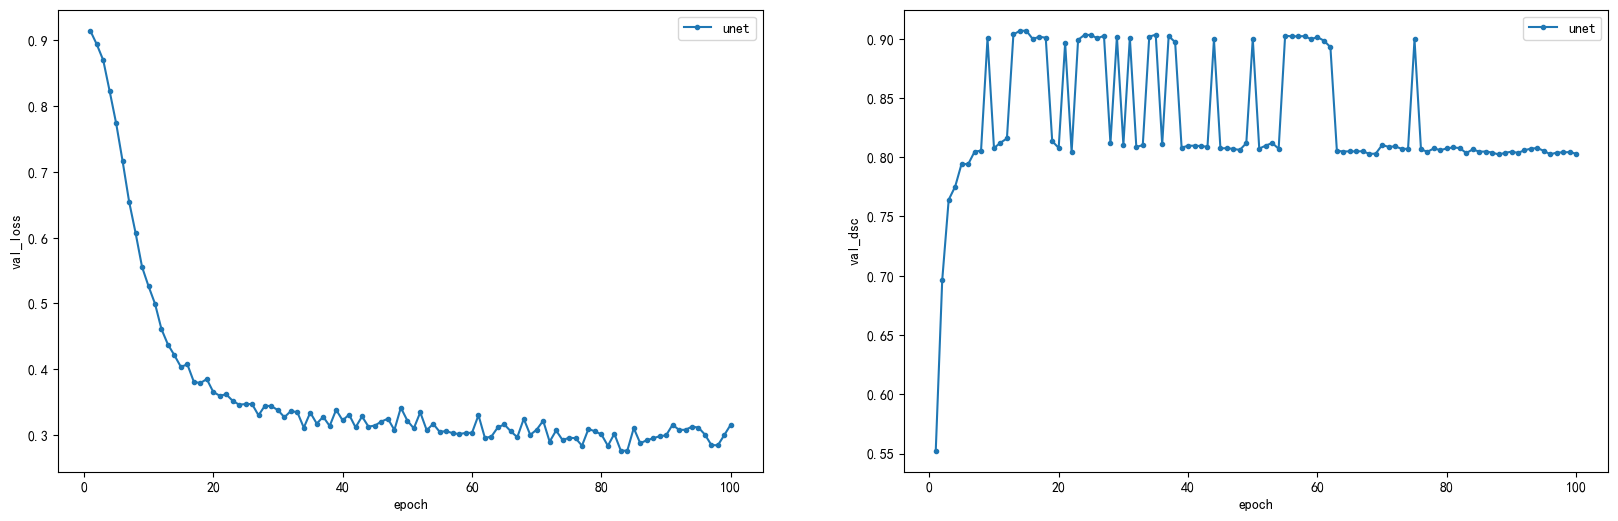

In [8]:
plt.figure(figsize=(20,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(121)
plt.plot(range(1,len(exec_result)+1),exec_result['val_loss'], marker='.', label ='unet')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.legend()
plt.subplot(122)
plt.plot(range(1,len(exec_result)+1),exec_result['val_dsc'], marker='.', label ='unet')
plt.xlabel('epoch')
plt.ylabel('val_dsc')
plt.legend()
plt.show()